In [1]:
import os
import time
import numpy as np

from simtk import unit
from simtk.openmm import app, LangevinIntegrator
from simtk.openmm.app import PDBFile

import parmed as pmd

from openforcefield.topology import Molecule, Topology
from openforcefield.typing.engines.smirnoff import ForceField

import openbabel
from openeye import oechem

import matplotlib.pyplot as plt
import mpld3

In [2]:
# choose the force field:
# not yet the release version!
openff_forcefield = ForceField('smirnoff99Frosst-1.1.0.offxml')

In [3]:
# function to convert openFF molecule (ligand) to a parmed structure
def ligandToPMD(ligand):
    ligand_positions = ligand.conformers[0]
    
    # Calculate am1bcc charges and fix them such that they add up to zero (4 digit precision)
    try:
        ligand.compute_partial_charges_am1bcc()
    except Exception as e:
        raise Exception('Error in charge calculation for ligand {}: {}'.format(ligand.name, e))
    # Give all atoms unique names so we can export to GROMACS
    for idx, atom in enumerate(ligand.atoms):
        atom.name = f'{atom.element.symbol}{idx}'
    
    # Do not assign H-bond constraints now, instead have ParmEd add them later
    del openff_forcefield._parameter_handlers['Constraints']

    ligand_topology = ligand.to_topology()
    try:
        ligand_system = openff_forcefield.create_openmm_system(ligand_topology, charge_from_molecules=[ligand])
    except Exception as e:
        raise Exception('Error in creating openmm system: {}'.format(e))
    # Create OpenMM Topology from OpenFF Topology
    omm_top = ligand_topology.to_openmm()


    # Convert OpenMM System to a ParmEd structure.
    pmd_structure = pmd.openmm.load_topology(omm_top, ligand_system, ligand_positions)

    return pmd_structure, ligand_topology, ligand_system, ligand_positions

In [4]:
# function for analyzing energy contributions of openMM energies
def forcegroupify(system):
    forcegroups = {}
    for i in range(system.getNumForces()):
        force = system.getForce(i)
        force.setForceGroup(i)
        forcegroups[(type(force)).__name__] = i
    return forcegroups

def getEnergyDecomposition(context, forcegroups):
    energies = {}
    for f, i in forcegroups.items():
        energies[f] = context.getState(getEnergy=True, groups=2**i).getPotentialEnergy()
    energies['TotalPotential'] = context.getState(getEnergy=True).getPotentialEnergy()
    return energies

# Convert the original pdb files to sdf files (including bond information) with openbabel

In [5]:
# convert pdbs to sdf
for target in ['jnk1', 'pde2', 'thrombin']:
    print('=== ' + target + ' ===')
    ligands = ! ls -d "systems/"$target/*/
    for lig in ligands:
        lig = lig.split('/')
        ligInPath  = 'systems/' + target + '/' + lig[-2] + '/' + lig[-2] + '.pdb'
        ligOutPath = 'systems/' + target + '/' + lig[-2] + '/' + lig[-2] + '.sdf'
        if os.path.isfile(ligInPath):
            print('    ', lig[-2])
            obConversion = openbabel.OBConversion()
            obConversion.SetInAndOutFormats("pdb", "sdf")
            mol = openbabel.OBMol()
            obConversion.ReadFile(mol, ligInPath)  # Open Babel will uncompress automatically
            obConversion.WriteFile(mol, ligOutPath)

=== jnk1 ===
     lig_17124-1
     lig_18624-1
     lig_18625-1
     lig_18626-1
     lig_18627-1
     lig_18628-1
     lig_18629-1
     lig_18630-1
     lig_18631-1
     lig_18632-1
     lig_18633-1
     lig_18634-1
     lig_18635-1
     lig_18636-1
     lig_18637-1
     lig_18638-1
     lig_18639-1
     lig_18652-1
     lig_18658-1
     lig_18659-1
     lig_18660-1
=== pde2 ===
     lig_43249674
     lig_48009208
     lig_48022468
     lig_48168913
     lig_48271249
     lig_49072088
     lig_49137374
     lig_49137530
     lig_49175789
     lig_49175828
     lig_49220392
     lig_49220548
     lig_49396360
     lig_49580115
     lig_49582390
     lig_49582468
     lig_49585367
     lig_49932129
     lig_49932714
     lig_50107616
     lig_50181001
=== thrombin ===
     lig_1a
     lig_1b
     lig_1c
     lig_1d
     lig_3a
     lig_3b
     lig_5
     lig_6a
     lig_6b
     lig_6e
     lig_7a


# Create gromacs topologies and coordinates of simple test molecules

In [6]:
# create simple test molecules
for target in ['testmols']:
    print('=== ' + target + ' ===')
    for lig in ['methane', 'ethane', 'ethanol', 'acetone', 'benzene', 'phenol', 'benzaldehyde']:
        print('    ', lig)
        ligand = Molecule.from_iupac(lig)
        ligand.name = lig
        ligand.generate_conformers()
        ligPath = 'systems/' + target + '/' + lig 
        ! mkdir -p $ligPath
        ligPath += '/' + lig
        
        try: 
            pmd_structure, ligand_topology, ligand_system, ligand_positions = ligandToPMD(ligand)
        except Exception as e:
            print('    ' + str(e))
            continue

        # Export sdf file
        ligand.to_file(ligPath+'.sdf', file_format='sdf')
        
        # Export GROMACS files.
        pmd_structure.save(ligPath+'.top', overwrite=True)
        pmd_structure.save(ligPath+'.gro', overwrite=True)

=== testmols ===
     methane
     ethane
     ethanol
     acetone
     benzene
     phenol
     benzaldehyde


# Convert sdf files (converted from pdb files) to gromacs topologies

In [7]:
# Convert sdf files (converted from pdb files) from Vytas to gromacs topologies 
# ATTENTION: this might be error prone because the original pdb files do not have bond information
for target in ['jnk1', 'pde2', 'thrombin']:
    print('=== ' + target + ' ===')
    ligands = ! ls -d "systems/"$target/*/
    for lig in ligands:
        lig = lig.split('/')
        ligPath= 'systems/' + target + '/' + lig[-2] + '/' + lig[-2]
        
        if os.path.isfile(ligPath + '.sdf'):
            print('    ', lig[-2])
            
            ligand = Molecule.from_file(ligPath+'.sdf')
            
            try: 
                pmd_structure, ligand_topology, ligand_system, ligand_positions = ligandToPMD(ligand)
            except Exception as e:
                print('    ' + str(e))
                continue

            # Export GROMACS files.
            pmd_structure.save(ligPath+'.top', overwrite=True)
            pmd_structure.save(ligPath+'.gro', overwrite=True)

=== jnk1 ===
     lig_17124-1
     lig_18624-1
     lig_18625-1
     lig_18626-1
     lig_18627-1
     lig_18628-1
     lig_18629-1
     lig_18630-1
     lig_18631-1
     lig_18632-1
     lig_18633-1
     lig_18634-1
     lig_18635-1
     lig_18636-1
     lig_18637-1
     lig_18638-1
     lig_18639-1
     lig_18652-1
     lig_18658-1
     lig_18659-1
     lig_18660-1
=== pde2 ===
     lig_43249674
     lig_48009208
     lig_48022468
     lig_48168913
     lig_48271249
     lig_49072088
     lig_49137374
     lig_49137530
     lig_49175789
     lig_49175828
     lig_49220392
     lig_49220548
     lig_49396360
     lig_49580115
     lig_49582390
     lig_49582468
     lig_49585367
     lig_49932129
     lig_49932714
     lig_50107616
     lig_50181001
=== thrombin ===
     lig_1a
     lig_1b
     lig_1c
     lig_1d
     lig_3a
     lig_3b
     lig_5
     lig_6a
     lig_6b
     lig_6e
     lig_7a


# Use sdf files with coordinates of pdb files

In [8]:
# For pde2 use sdf of SI of https://www.nature.com/articles/s41598-018-23039-5
target = 'pde2_sdf'
print('=== pde2_sdf ===')
ifs = oechem.oemolistream()
ifs.SetFormat(oechem.OEFormat_SDF)
if ifs.open('systems/pde2_sdf/4D08_ligands_input.sdf'):
    moldb = oechem.OEMolDatabase(ifs)
    nummols = moldb.NumMols()
    for idx in range(moldb.GetMaxMolIdx()):
        title = moldb.GetTitle(idx)
        mol = oechem.OEMol()
        moldb.GetMolecule(mol, idx)
        
        conftarget = 'pde2'
        ligands = ! ls -d 'systems/'$conftarget/*/
        for lig in ligands:
            lig = lig.split('/')
            ligPath = 'systems/' + conftarget+'/'+lig[-2]+'/'+lig[-2]
        
            ligand = Molecule.from_openeye(mol)
            if os.path.isfile(ligPath+'.pdb'):
                pdb = app.PDBFile(ligPath + ".pdb")
                openmm_topology = pdb.topology
                try:
                    ligand_topology = Topology.from_openmm(openmm_topology, unique_molecules=[ligand])
                    print('    {}    {}'.format(title, lig[-2]))
                    break
                except:
                    continue
        else:
            print('PDB coordinates not found')
        try:
            # get pdb positions
            ligand_positions = pdb.getPositions()
            
            # set ligand conformer to pdb positions, Attention: This only works if the order of atoms is the same in the pdb file and the ligand class
            ligand.conformers[0] = unit.Quantity(np.array(ligand_positions.value_in_unit(unit.angstrom)), unit.angstrom)
            
            # Calculate am1bcc charges and fix them such that they add up to zero (4 digit precision)
            try:
                ligand.compute_partial_charges_am1bcc()
            except Exception as e:
                raise Exception('Error in charge calculation for ligand {}: {}'.format(ligand.name, e))
            # Give all atoms unique names so we can export to GROMACS
            for idx, atom in enumerate(ligand.atoms):
                atom.name = f'{atom.element.symbol}{idx}'
                ligand_topology.atom(idx).atom.name = atom.name

            # Do not assign H-bond constraints now, instead have ParmEd add them later
            del openff_forcefield._parameter_handlers['Constraints']

            try:
                ligand_system = openff_forcefield.create_openmm_system(ligand_topology, charge_from_molecules=[ligand])
            except Exception as e:
                raise Exception('Error in creating openmm system: {}'.format(e))
            # Create OpenMM Topology from OpenFF Topology
            omm_top = ligand_topology.to_openmm()


            # Convert OpenMM System to a ParmEd structure.
            pmd_structure = pmd.openmm.load_topology(omm_top, ligand_system, ligand_positions)
        except Exception as e:
            print('    ' + str(e))
            continue

        # Output path.
        ligPath = 'systems/' + target + '/' + lig[-2] 
        ! mkdir -p $ligPath
        ligPath = 'systems/' + target + '/' + lig[-2] + '/' + lig[-2]
        
        # Export sdf file
        ligand.to_file(ligPath+'.sdf', file_format='sdf')
        
        # Export GROMACS files.        
        pmd_structure.save(ligPath+'.top', overwrite=True)
        pmd_structure.save(ligPath+'.gro', overwrite=True)
else: 
    print('Error in opening file')

=== pde2_sdf ===
    2    lig_43249674


/opt/anaconda3/envs/off-demo/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:536: UserWarning: WARNING: duplicate atom (HETATM   48  H   Q2T A1918       0.893  21.368  19.284  0.00  0.00           H  , HETATM   30  H   Q2T A1918      -3.657  22.626  20.790  0.00  0.00           H  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/opt/anaconda3/envs/off-demo/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:536: UserWarning: WARNING: duplicate atom (HETATM   31  H   Q2T A1918      -3.657  22.626  20.790  0.00  0.00           H  , HETATM    1  H   Q2T A1918      -3.091  22.411  18.274  0.00 18.25           H  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/opt/anaconda3/envs/off-demo/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:536: 

    4    lig_49137530
    6    lig_48009208
    7    lig_48022468
    8    lig_48168913
    9    lig_49137374
    10    lig_48271249


/opt/anaconda3/envs/off-demo/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:536: UserWarning: WARNING: duplicate atom (HETATM   33  C   Q2T A1918      -5.453  22.635  17.072  0.00  0.00           C  , HETATM    6  C   Q2T A1918      -0.096  21.639  19.622  0.00 18.14           C  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/opt/anaconda3/envs/off-demo/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:536: UserWarning: WARNING: duplicate atom (HETATM   56  H   Q2T A1918      -5.421  21.581  16.797  0.00  0.00           H  , HETATM   54  H   Q2T A1918       0.893  21.368  19.284  0.00  0.00           H  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/opt/anaconda3/envs/off-demo/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:536: 

    11    lig_49220392
    12    lig_49580115
    13    lig_49220548
    14    lig_49396360
    15    lig_49175828
    16    lig_49072088


/opt/anaconda3/envs/off-demo/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:536: UserWarning: WARNING: duplicate atom (HETATM   52  C   Q2T A1918      -4.328  24.628  18.529  0.00  0.00           C  , HETATM   51  C   Q2T A1918      -5.107  25.522  17.600  0.00  0.00           C  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/opt/anaconda3/envs/off-demo/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:536: UserWarning: WARNING: duplicate atom (HETATM   53  C   Q2T A1918      -5.531  25.378  19.038  0.00  0.00           C  , HETATM   52  C   Q2T A1918      -4.328  24.628  18.529  0.00  0.00           C  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/opt/anaconda3/envs/off-demo/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:536: 

    17    lig_49582468


/opt/anaconda3/envs/off-demo/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:536: UserWarning: WARNING: duplicate atom (HETATM   56  H   Q2T A1918      -3.585  21.519  17.446  0.00  0.00           H  , HETATM   55  H   Q2T A1918      -2.900  22.990  17.111  0.00  0.00           H  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))


    18    lig_49932129
    19    lig_49932714
    20    lig_49585367
    21    lig_49175789


/opt/anaconda3/envs/off-demo/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:536: UserWarning: WARNING: duplicate atom (HETATM   60  H   Q2T A1918      -3.584  21.515  17.446  0.00  0.00           H  , HETATM   59  H   Q2T A1918      -2.901  22.988  17.111  0.00  0.00           H  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))


    22    lig_50181001
    23    lig_50107616
    24    lig_49582390


# Run single point energies and minimizations in openMM and Gromacs

In [9]:
# initialize dicts to store gromacs and openMM energies
gromacsEnergies = {}
openmmEnergies = {}
gromacsMinimizedEnergies = {}
openmmMinimizedEnergies = {}

#### openMM

In [10]:
 # run it in openMM
for target in ['testmols',  'jnk1', 'pde2', 'thrombin', 'pde2_sdf']:
    openmmEnergies[target] = {}
    openmmMinimizedEnergies[target] = {}
    print('=' * 60)
    print('=== ' + target + ' ===')
    print('=' * 60)
    ligands = ! ls -d 'systems/'$target/*/
    for lig in ligands:
        lig = lig.split('/')
        ligPath = 'systems/' + target + '/' + lig[-2] + '/' + lig[-2]
        
        if os.path.isfile(ligPath+'.gro') and os.path.isfile(ligPath+'.top'):
            print('-' * 60)
            print('--- ' + lig[-2] + ' ---')
            print('-' * 60)
            gro_positions = pmd.load_file(ligPath + '.gro')
            
            ligand_topology = pmd.load_file(ligPath + '.top', box = gro_positions.box)
            ligand_system = ligand_topology.createSystem(nonbondedMethod = app.NoCutoff, removeCMMotion = False)

            integrator = LangevinIntegrator(300*unit.kelvin, 
                            1/unit.picosecond, 
                            0.002*unit.picoseconds)

             
            simulation = app.Simulation(ligand_topology, ligand_system, integrator)
        
            simulation.context.setPositions(gro_positions.positions)
        
            energies = getEnergyDecomposition(simulation.context, forcegroupify(ligand_system))
            openmmEnergies[target][lig[-2]] = energies
            print('     Emin  : {}'.format(energies['TotalPotential']))
    
            simulation.minimizeEnergy()
            minimized_coords = simulation.context.getState(getPositions=True).getPositions()
            
            energies = getEnergyDecomposition(simulation.context, forcegroupify(ligand_system))
            openmmMinimizedEnergies[target][lig[-2]] = energies
            print('     Estart: {}'.format(energies['TotalPotential']))

=== testmols ===
------------------------------------------------------------
--- acetone ---
------------------------------------------------------------
     Emin  : -68.90615055329437 kJ/mol
     Estart: -74.99239525303838 kJ/mol
------------------------------------------------------------
--- benzaldehyde ---
------------------------------------------------------------
     Emin  : 60.824465726524 kJ/mol
     Estart: 55.595423511866365 kJ/mol
------------------------------------------------------------
--- benzene ---
------------------------------------------------------------
     Emin  : 25.623977665341442 kJ/mol
     Estart: 23.471812302520892 kJ/mol
------------------------------------------------------------
--- ethane ---
------------------------------------------------------------
     Emin  : 6.507785203224147 kJ/mol
     Estart: 4.330234330612461 kJ/mol
------------------------------------------------------------
--- ethanol ---
-------------------------------------------

     Emin  : 460.7882821137297 kJ/mol
     Estart: 356.4083585806578 kJ/mol
------------------------------------------------------------
--- lig_49175789 ---
------------------------------------------------------------
     Emin  : 453.7162772037326 kJ/mol
     Estart: 333.17937425316467 kJ/mol
------------------------------------------------------------
--- lig_49175828 ---
------------------------------------------------------------
     Emin  : 420.23988529143753 kJ/mol
     Estart: 304.24985206358883 kJ/mol
------------------------------------------------------------
--- lig_49220392 ---
------------------------------------------------------------
     Emin  : 432.48079420045576 kJ/mol
     Estart: 319.22215245560255 kJ/mol
------------------------------------------------------------
--- lig_49220548 ---
------------------------------------------------------------
     Emin  : 443.29067761076976 kJ/mol
     Estart: 331.292122095653 kJ/mol
-------------------------------------------

     Emin  : 634.8154735681711 kJ/mol
     Estart: 510.87576634279714 kJ/mol
------------------------------------------------------------
--- lig_49582468 ---
------------------------------------------------------------
     Emin  : 296.9138132623247 kJ/mol
     Estart: 175.85254841204983 kJ/mol
------------------------------------------------------------
--- lig_49585367 ---
------------------------------------------------------------
     Emin  : 491.44385552231756 kJ/mol
     Estart: 371.5439460320508 kJ/mol
------------------------------------------------------------
--- lig_49932129 ---
------------------------------------------------------------
     Emin  : 355.41177165417395 kJ/mol
     Estart: 250.62844071300643 kJ/mol
------------------------------------------------------------
--- lig_49932714 ---
------------------------------------------------------------
     Emin  : 430.7851921544668 kJ/mol
     Estart: 329.176382393365 kJ/mol
--------------------------------------------

In [11]:
# needed to have some sleep times between the system calls because writing of files was not yet finished
# run gromacs to get energies
for target in ['testmols',  'jnk1', 'pde2', 'thrombin', 'pde2_sdf']:
    gromacsEnergies[target] = {}
    gromacsMinimizedEnergies[target] = {}
    print('=' * 60)
    print('=== ' + target + ' ===')
    print('=' * 60)
    ligands = ! ls -d 'systems/'$target/*/
    for lig in ligands:
        lig = lig.split('/')
        ligPath = 'systems/' + target + '/' + lig[-2] + '/' + lig[-2]
        
        if os.path.isfile(ligPath+'.gro') and os.path.isfile(ligPath+'.top'):
            print('-' * 60)
            print('--- ' + lig[-2] + ' ---')
            print('-' * 60)
            dir = 'systems/' + target + '/' + lig[-2]
            ! rm -f $dir/\#*
            
            # single point energy of starting structure
            energies = ''
            count = 0
            while not energies and count < 10:
                print('    Calculate single-point energy ...')
                os.system("gmx grompp -f ./input/gromacs/md.mdp -c {}.gro -p {}.top -o {}_md.tpr &> {}_grompp.out".format(ligPath, ligPath, ligPath, ligPath))
                time.sleep(2)
                os.system("gmx mdrun  -s {}_md.tpr -rerun {}.gro -e {}.edr -g {}.log &> {}_mdrun.out".format(ligPath, ligPath, ligPath, ligPath, ligPath))
                time.sleep(2)
                energies = ! cat $ligPath'.log' | grep -A 4 "Energies"
                count += 1
            ene_dict = {'Bond': 0.0, 'Angle': 0.0, 'Proper Dih.': 0.0, 'LJ-14': 0.0, 'Coulomb-14': 0.0, 'LJ (SR)': 0.0, 'Coulomb (SR)': 0.0, 'Potential': 0.0}
            for i in range(int((len(energies)-1)/2)):
                keys = [s.strip() for s in energies[1+i*2].split('  ') if s]
                values = energies[2+i*2].split()
                for key, val in zip(keys, values):
                    ene_dict[key] = float(val)
            print('    ' + str(ene_dict))
            gromacsEnergies[target][lig[-2]] = ene_dict
                        
            # energy minimization
            minEnergies = ''
            count = 0
            while not minEnergies and count < 10:
                print('    Energy minimize ligand ...')
                os.system("gmx grompp -f ./input/gromacs/minim.mdp -c {}.gro -p {}.top -o {}_em.tpr &> {}_grompp_em.out".format(ligPath, ligPath, ligPath, ligPath))
                os.system("gmx mdrun  -deffnm {}_em &> {}_mdrun_em.out".format(ligPath, ligPath))
                time.sleep(2)
                # getting the last energies entry
                minEnergies = ! tac $ligPath'_em.log' | grep -m 1 -B 4 "Energies" | tac 
                count += 1
            
            minEne_dict = {'Bond': 0.0, 'Angle': 0.0, 'Proper Dih.': 0.0, 'LJ-14': 0.0, 'Coulomb-14': 0.0, 'LJ (SR)': 0.0, 'Coulomb (SR)': 0.0, 'Potential': 0.0}
            for i in range(int((len(minEnergies)-1)/2)):
                keys = [s.strip() for s in minEnergies[1+i*2].split('  ') if s]
                values = minEnergies[2+i*2].split()
                for key, val in zip(keys, values):
                    minEne_dict[key] = float(val)
            print('    ' + str(minEne_dict))
            gromacsMinimizedEnergies[target][lig[-2]] = minEne_dict

=== testmols ===
------------------------------------------------------------
--- acetone ---
------------------------------------------------------------
    Calculate single-point energy ...
    {'Bond': 1.08841, 'Angle': 1.92164, 'Proper Dih.': 22.1069, 'LJ-14': 2.54956, 'Coulomb-14': -111.31, 'LJ (SR)': -0.0705044, 'Coulomb (SR)': 14.8081, 'Potential': -68.9061}
    Energy minimize ligand ...
    {'Bond': 1.08841, 'Angle': 1.92164, 'Proper Dih.': 22.1069, 'LJ-14': 2.54956, 'Coulomb-14': -111.31, 'LJ (SR)': -0.0705044, 'Coulomb (SR)': 14.8081, 'Potential': 0.0, 'Potential Pressure (bar)': -68.9061}
------------------------------------------------------------
--- benzaldehyde ---
------------------------------------------------------------
    Calculate single-point energy ...
    {'Bond': 2.79133, 'Angle': 1.50461, 'Proper Dih.': 0.0368528, 'LJ-14': 18.445, 'Coulomb-14': 46.8819, 'LJ (SR)': -0.744951, 'Coulomb (SR)': -8.0903, 'Potential': 60.8244}
    Energy minimize ligand ...
    

    {'Bond': 5.17614, 'Angle': 34.225, 'Proper Dih.': 26.2613, 'LJ-14': 58.4366, 'Coulomb-14': -2742.07, 'LJ (SR)': -16.0727, 'Coulomb (SR)': 1521.69, 'Potential': 0.0, 'Potential Pressure (bar)': -1112.36}
------------------------------------------------------------
--- lig_18630-1 ---
------------------------------------------------------------
    Calculate single-point energy ...
    {'Bond': 16.9695, 'Angle': 39.1227, 'Proper Dih.': 25.4189, 'LJ-14': 59.9933, 'Coulomb-14': -2723.14, 'LJ (SR)': -15.9702, 'Coulomb (SR)': 1505.18, 'Potential': -1092.43}
    Energy minimize ligand ...
    {'Bond': 5.74766, 'Angle': 33.6483, 'Proper Dih.': 25.7154, 'LJ-14': 59.21, 'Coulomb-14': -2722.78, 'LJ (SR)': -15.8787, 'Coulomb (SR)': 1505.67, 'Potential': 0.0, 'Potential Pressure (bar)': -1108.67}
------------------------------------------------------------
--- lig_18631-1 ---
------------------------------------------------------------
    Calculate single-point energy ...
    {'Bond': 24.5539,

    {'Bond': 12.693, 'Angle': 64.2133, 'Proper Dih.': 39.6176, 'LJ-14': 64.1862, 'Coulomb-14': -3359.46, 'LJ (SR)': -18.545, 'Coulomb (SR)': 1635.76, 'Potential': 0.0, 'Potential Pressure (bar)': -1561.54}
=== pde2 ===
------------------------------------------------------------
--- lig_43249674 ---
------------------------------------------------------------
    Calculate single-point energy ...
    {'Bond': 47.3782, 'Angle': 119.246, 'Proper Dih.': 30.0847, 'LJ-14': 75.0704, 'Coulomb-14': 291.786, 'LJ (SR)': -25.9425, 'Coulomb (SR)': -100.92, 'Potential': 436.703}
    Energy minimize ligand ...
    {'Bond': 9.59608, 'Angle': 103.285, 'Proper Dih.': 30.4682, 'LJ-14': 69.4695, 'Coulomb-14': 291.113, 'LJ (SR)': -26.4468, 'Coulomb (SR)': -99.7371, 'Potential': 0.0, 'Potential Pressure (bar)': 377.749}
------------------------------------------------------------
--- lig_48009208 ---
------------------------------------------------------------
    Calculate single-point energy ...
    {'Bo

    {'Bond': 51.9837, 'Angle': 128.567, 'Proper Dih.': 42.3404, 'LJ-14': 77.0624, 'Coulomb-14': 319.55, 'LJ (SR)': -27.6098, 'Coulomb (SR)': -136.049, 'Potential': 455.845}
    Energy minimize ligand ...
    {'Bond': 12.0074, 'Angle': 112.567, 'Proper Dih.': 42.4455, 'LJ-14': 73.9936, 'Coulomb-14': 318.34, 'LJ (SR)': -27.4605, 'Coulomb (SR)': -135.111, 'Potential': 0.0, 'Potential Pressure (bar)': 396.782}
------------------------------------------------------------
--- lig_49582390 ---
------------------------------------------------------------
    Calculate single-point energy ...
    {'Bond': 58.077, 'Angle': 140.845, 'Proper Dih.': 82.7378, 'LJ-14': 79.1168, 'Coulomb-14': 367.265, 'LJ (SR)': -29.4614, 'Coulomb (SR)': -161.951, 'Potential': 637.691, 'Improper Dih.': 101.062}
    Energy minimize ligand ...
    {'Bond': 11.9604, 'Angle': 115.917, 'Proper Dih.': 83.0589, 'LJ-14': 75.9241, 'Coulomb-14': 365.418, 'LJ (SR)': -29.3674, 'Coulomb (SR)': -160.908, 'Potential': 0.0, 'Improper

    Calculate single-point energy ...
    {'Bond': 9.4393, 'Angle': 37.6151, 'Proper Dih.': 68.9108, 'LJ-14': 42.3017, 'Coulomb-14': 987.928, 'LJ (SR)': -33.4057, 'Coulomb (SR)': -773.991, 'Potential': 338.799}
    Energy minimize ligand ...
    {'Bond': 9.12908, 'Angle': 31.5846, 'Proper Dih.': 68.7099, 'LJ-14': 43.6332, 'Coulomb-14': 983.386, 'LJ (SR)': -33.1066, 'Coulomb (SR)': -772.882, 'Potential': 0.0, 'Potential Pressure (bar)': 330.454}
------------------------------------------------------------
--- lig_6a ---
------------------------------------------------------------
    Calculate single-point energy ...
    {'Bond': 9.41641, 'Angle': 37.6977, 'Proper Dih.': 69.0777, 'LJ-14': 44.8535, 'Coulomb-14': 988.436, 'LJ (SR)': -32.5272, 'Coulomb (SR)': -779.487, 'Potential': 337.467}
    Energy minimize ligand ...
    {'Bond': 9.29067, 'Angle': 31.6705, 'Proper Dih.': 68.9093, 'LJ-14': 45.9308, 'Coulomb-14': 984.136, 'LJ (SR)': -32.6625, 'Coulomb (SR)': -778.712, 'Potential': 0.0, '

    Calculate single-point energy ...
    {'Bond': 60.2339, 'Angle': 127.506, 'Proper Dih.': 47.8157, 'LJ-14': 81.9558, 'Coulomb-14': 258.081, 'LJ (SR)': -25.9723, 'Coulomb (SR)': -129.9, 'Potential': 419.72}
    Energy minimize ligand ...
    {'Bond': 11.3325, 'Angle': 114.644, 'Proper Dih.': 48.0122, 'LJ-14': 76.8584, 'Coulomb-14': 257.361, 'LJ (SR)': -26.5328, 'Coulomb (SR)': -128.649, 'Potential': 0.0, 'Potential Pressure (bar)': 353.026}
------------------------------------------------------------
--- lig_49220392 ---
------------------------------------------------------------
    Calculate single-point energy ...
    {'Bond': 60.5761, 'Angle': 126.648, 'Proper Dih.': 39.2396, 'LJ-14': 78.6108, 'Coulomb-14': 301.733, 'LJ (SR)': -26.618, 'Coulomb (SR)': -147.84, 'Potential': 432.349}
    Energy minimize ligand ...
    {'Bond': 11.111, 'Angle': 114.114, 'Proper Dih.': 39.3251, 'LJ-14': 73.8962, 'Coulomb-14': 301.174, 'LJ (SR)': -26.9858, 'Coulomb (SR)': -146.649, 'Potential': 0.0, 

# Summarize results

#### Single point energies

In [12]:
energies={}
differing_molecules = []
print('    {:20s}: {:11s}    {:11s}    {:11s}'.format('Energy contrib', 'openMM', 'Gromacs', 'Difference'))
for target in ['testmols', 'jnk1', 'pde2', 'pde2_sdf', 'thrombin']:
    print('=== ' + target + ' ===')
    energies[target] = {}
    for key in openmmEnergies[target].keys():
        print(key)
        energies[target][key] = {}
        for kk, ene in openmmEnergies[target][key].items():
            if kk == "NonbondedForce":
                gromacs_ene = sum([gromacsEnergies[target][key][x] for x in ['LJ-14', 'Coulomb-14', 'LJ (SR)', 'Coulomb (SR)']])
            elif kk == 'PeriodicTorsionForce':
                gromacs_ene = gromacsEnergies[target][key]['Proper Dih.']
            elif kk == 'HarmonicAngleForce':
                gromacs_ene = gromacsEnergies[target][key]['Angle']
            elif kk == 'HarmonicBondForce':
                gromacs_ene = gromacsEnergies[target][key]['Bond']
            elif kk == 'TotalPotential':
                gromacs_ene = gromacsEnergies[target][key]['Potential']
            else:
                gromacs_ene = 0.0
                print('Error: OpenMM Energy not known: ' + kk)
            totdiff = ene.value_in_unit(unit.kilojoules_per_mole)-gromacs_ene
            if np.fabs(totdiff) > 0.01:
                differing_molecules.append([target, key])
            energies[target][key][kk]=np.array([ene.value_in_unit(unit.kilojoules_per_mole), gromacs_ene, ene.value_in_unit(unit.kilojoules_per_mole)-gromacs_ene])
            print('    {:20s}: {:8.2f}    {:8.2f}    {:8.2f}'.format(kk, ene.value_in_unit(unit.kilojoules_per_mole), gromacs_ene, ene.value_in_unit(unit.kilojoules_per_mole)-gromacs_ene))

    Energy contrib      : openMM         Gromacs        Difference 
=== testmols ===
acetone
    HarmonicBondForce   :     1.09        1.09        0.00
    HarmonicAngleForce  :     1.92        1.92       -0.00
    PeriodicTorsionForce:    22.11       22.11        0.00
    NonbondedForce      :   -94.02      -94.02       -0.00
    TotalPotential      :   -68.91      -68.91       -0.00
benzaldehyde
    HarmonicBondForce   :     2.79        2.79        0.00
    HarmonicAngleForce  :     1.50        1.50        0.00
    PeriodicTorsionForce:     0.04        0.04       -0.00
    NonbondedForce      :    56.49       56.49        0.00
    TotalPotential      :    60.82       60.82        0.00
benzene
    HarmonicBondForce   :     0.88        0.88        0.00
    HarmonicAngleForce  :     0.09        0.09        0.00
    PeriodicTorsionForce:     0.02        0.02       -0.00
    NonbondedForce      :    24.63       24.63       -0.00
    TotalPotential      :    25.62       25.62       -0.00
e

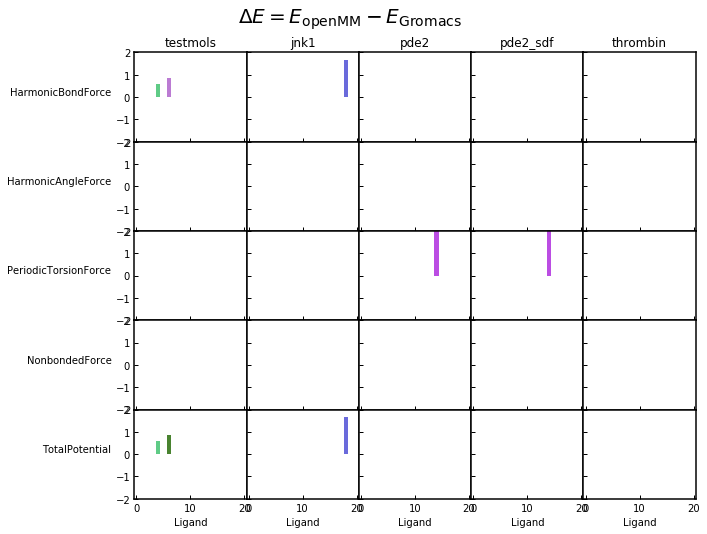

In [13]:
mpld3.enable_notebook()

plt.rcParams['figure.figsize'] = [12, 8]

fig, ax = plt.subplots(5, 5, sharex=True, sharey=True)

for ti, (t, ldict) in enumerate(energies.items()):
    for li, (l, edict) in enumerate(ldict.items()):
        for ei, (e, ene) in enumerate(edict.items()):
            ax[ei][ti].bar(li, ene[2])
for a in ax:
    for aa in a:
        aa.set_ylim(-2,2)
for a, l in zip(ax[:,0], energies['jnk1']['lig_17124-1'].keys()):
    a.set_ylabel(l, rotation=0, ha='right')
for a, l in zip(ax[-1,:], energies.keys()):
    a.set_xlabel('Ligand', rotation=0)
    #a.set_xticklabels(energies[l].keys())
for a, l in zip(ax[0,:], energies.keys()):
    a.set_title(l, rotation=0)
plt.gcf().suptitle('$\Delta E=E_{\mathrm{openMM}}-E_{\mathrm{Gromacs}}$', fontsize=20)
plt.savefig('energy_differences_openmm_gromacs.png')
plt.show()

#### Molecules with deviation > 0.01 kJ/mol in one of the terms

=== jnk1 ===
------------------------------------------------------------
--- lig_18658-1 ---
------------------------------------------------------------
    HarmonicBondForce   :    40.14       38.49        1.65
    HarmonicAngleForce  :    56.77       56.77       -0.00
    PeriodicTorsionForce:    39.85       39.85        0.00
    NonbondedForce      : -1170.29    -1170.30        0.00
    TotalPotential      : -1033.53    -1035.18        1.65
=== pde2 ===
------------------------------------------------------------
--- lig_49582390 ---
------------------------------------------------------------
    HarmonicBondForce   :    58.08       58.08       -0.00
    HarmonicAngleForce  :   140.85      140.84        0.00
    PeriodicTorsionForce:   183.80       82.74      101.06
    NonbondedForce      :   254.97      254.97       -0.00
    TotalPotential      :   637.69      637.69        0.00
=== pde2_sdf ===
------------------------------------------------------------
--- lig_49582390 ---


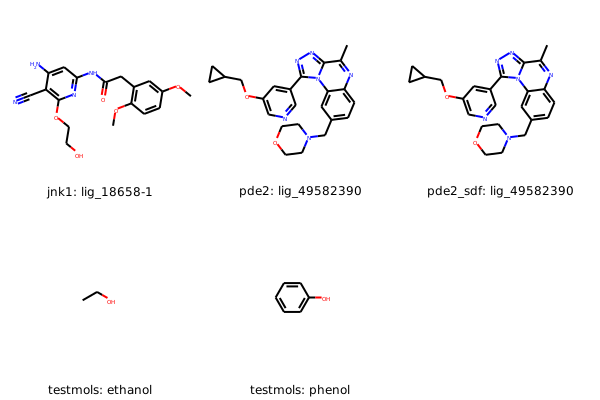

In [14]:
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
import rdkit.Chem.Draw as D
rdkitMols = []
for i, (target, ligand) in enumerate(np.unique(differing_molecules, axis=0)):
    print('=' * 60)
    print('=== ' + target + ' ===')
    print('=' * 60)
    ligPath = 'systems/' + target + '/' + ligand + '/' + ligand
        
    if os.path.isfile(ligPath+'.sdf'):
        print('-' * 60)
        print('--- ' + ligand + ' ---')
        print('-' * 60)
        mols = AllChem.SDMolSupplier(ligPath+'.sdf')
        for mol in mols:
            AllChem.Compute2DCoords(mol)
            mol.SetProp('_Name', target + ': ' + ligand)
            rdkitMols.append(mol)
    for k, item in energies[target][ligand].items():
        print('    {:20s}: {:8.2f}    {:8.2f}    {:8.2f}'.format(k, item[0], item[1], item[2]))
Draw.MolsToGridImage(rdkitMols, legends=[x.GetProp('_Name') for x in rdkitMols])

#### Minimized Energies

In [15]:
minEnergies={}
print('    {:20s}: {:11s}    {:11s}    {:11s}'.format('Energy contrib', 'openMM', 'Gromacs', 'Difference'))
for target in ['testmols', 'jnk1', 'pde2', 'pde2_sdf', 'thrombin']:
    print('=== ' + target + ' ===')
    minEnergies[target] = {}
    for key in openmmMinimizedEnergies[target].keys():
        print(key)
        minEnergies[target][key] = {}
        for kk, ene in openmmMinimizedEnergies[target][key].items():
            if kk == "NonbondedForce":
                gromacs_ene = sum([gromacsMinimizedEnergies[target][key][x] for x in ['LJ-14', 'Coulomb-14', 'LJ (SR)', 'Coulomb (SR)']])
            elif kk == 'PeriodicTorsionForce':
                gromacs_ene = gromacsMinimizedEnergies[target][key]['Proper Dih.']
            elif kk == 'HarmonicAngleForce':
                gromacs_ene = gromacsMinimizedEnergies[target][key]['Angle']
            elif kk == 'HarmonicBondForce':
                gromacs_ene = gromacsMinimizedEnergies[target][key]['Bond']
            elif kk == 'TotalPotential':
                gromacs_ene = gromacsMinimizedEnergies[target][key]['Potential']
            else:
                print('Error: OpenMM Energy not known.')
            minEnergies[target][key][kk]=np.array([ene.value_in_unit(unit.kilojoules_per_mole), gromacs_ene, ene.value_in_unit(unit.kilojoules_per_mole)-gromacs_ene])
            print('    {:20s}: {:8.2f}    {:8.2f}    {:8.2f}'.format(kk, ene.value_in_unit(unit.kilojoules_per_mole), gromacs_ene, ene.value_in_unit(unit.kilojoules_per_mole)-gromacs_ene))

    Energy contrib      : openMM         Gromacs        Difference 
=== testmols ===
acetone
    HarmonicBondForce   :     0.04        1.09       -1.05
    HarmonicAngleForce  :     0.04        1.92       -1.88
    PeriodicTorsionForce:    20.05       22.11       -2.06
    NonbondedForce      :   -95.11      -94.02       -1.09
    TotalPotential      :   -74.99        0.00      -74.99
benzaldehyde
    HarmonicBondForce   :     0.97        0.73        0.24
    HarmonicAngleForce  :     0.31        0.74       -0.44
    PeriodicTorsionForce:     0.00        0.02       -0.02
    NonbondedForce      :    54.32       55.15       -0.83
    TotalPotential      :    55.60        0.00       55.60
benzene
    HarmonicBondForce   :     0.49        0.26        0.24
    HarmonicAngleForce  :     0.00        0.05       -0.05
    PeriodicTorsionForce:     0.00        0.01       -0.01
    NonbondedForce      :    22.98       23.60       -0.63
    TotalPotential      :    23.47        0.00       23.47
e

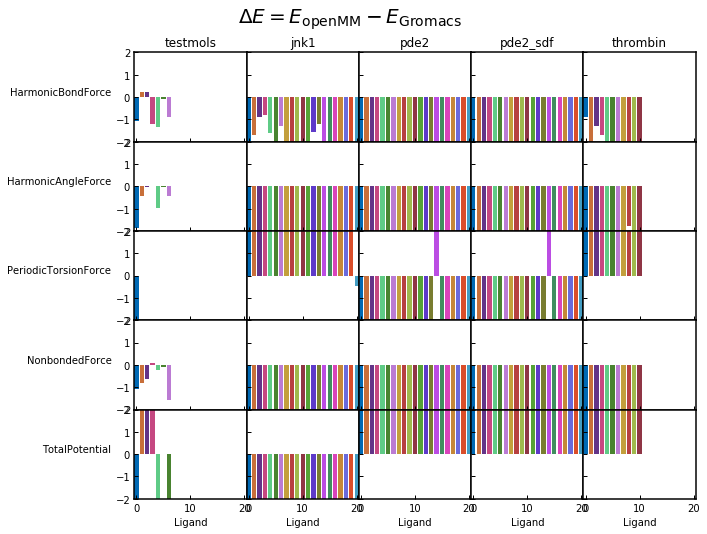

In [16]:
mpld3.enable_notebook()

plt.rcParams['figure.figsize'] = [12, 8]

fig, ax = plt.subplots(5, 5, sharex=True, sharey=True)

for ti, (t, ldict) in enumerate(minEnergies.items()):
    for li, (l, edict) in enumerate(ldict.items()):
        for ei, (e, ene) in enumerate(edict.items()):
            ax[ei][ti].bar(li, ene[2])
for a in ax:
    for aa in a:
        aa.set_ylim(-2,2)
for a, l in zip(ax[:,0], minEnergies['jnk1']['lig_17124-1'].keys()):
    a.set_ylabel(l, rotation=0, ha='right')
for a, l in zip(ax[-1,:], minEnergies.keys()):
    a.set_xlabel('Ligand', rotation=0)
    #a.set_xticklabels(energies[l].keys())
for a, l in zip(ax[0,:], energies.keys()):
    a.set_title(l, rotation=0)
plt.gcf().suptitle('$\Delta E=E_{\mathrm{openMM}}-E_{\mathrm{Gromacs}}$', fontsize=20)
plt.savefig('energy_minimized_differences_openmm_gromacs.png')
plt.show()